In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np 
from multiprocessing import Pool
import time 
import random
import IPython.display as ipd
import pyaudio
import sys
import librosa
import librosa.display
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
sys.path.append('../../')

import pdb
#import utils.audio as a
#import utils.plots as plots
import utils as utils

/opt/anaconda3/envs/aip37/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Load audio files into dataset

In [10]:
# load (fe)male audio sequences without alpha, beta 
PATH = '../../datasets/freesound.org/wav_denoised/'
SR = 22050 

dataset = utils.audio.loadAudioFiles(PATH, SR)
dataset_chunks = utils.audio.createAudioChunks(dataset, 200, SR)

100%|██████████| 384/384 [00:00<00:00, 2592.78it/s]


In [16]:
# concatenate chunks
chunk_seq = np.array(dataset_chunks)
print(list(filter(lambda x: len(x)==0, chunk_seq)))
chunks = np.concatenate((chunk_seq[:]), axis=0)
print(chunks.shape)
# # check if empy list, that is when audio is smaller than chunk size
print(list(filter(lambda x: len(x)==0, dataset_chunks))) 

[]
(16073, 4410)
[]


In [20]:
chunks.shape, dataset_chunks.shape

((16073, 4410), (383,))

In [4]:
# plot multiple audios at the same time
utils.audio.playMultiAudio(dataset_chunks[1])

In [7]:
num_points = 1000
num_feats = 32
num_chunks = chunks.shape[0]
#X = np.zeros((num_chunks, 44*num_feats))
X = []
for i in tqdm(range(num_chunks)):
    #pdb.set_trace()
    #X[i, :] = librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats).flatten()
    X.append(np.array(librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats))[1:num_feats].flatten())

 41%|████      | 2572/6327 [00:05<00:08, 435.15it/s]


KeyboardInterrupt: 

In [26]:
from skimage.transform import resize
#num_points = 1000
num_feats = 6
num_chunks = chunks.shape[0]
hop_length = 256
#X = np.zeros((num_chunks, 44*num_feats))
X = []
t = time.time()
# do stuff
for i in tqdm(range(num_chunks)):
    #pdb.set_trace()
     # mfcc
    feat = librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats).flatten() # 13x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    ## chroma
#     chroma_cq = librosa.feature.chroma_cqt(y=chunks[i, :], sr=SR, hop_length=hop_length).flatten() #12x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    # RMS mag spec
    rms = librosa.feature.rms(y=chunks[i, :]).flatten() #1x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    # Spectral centroid
    cent = librosa.feature.spectral_centroid(y=chunks[i, :], sr=SR).flatten()#1x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    # Spectral bandwidth
    band = librosa.feature.spectral_bandwidth(y=chunks[i, :], sr=SR).flatten()#1x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    # Spectral flatness
    flat = librosa.feature.spectral_flatness(y=chunks[i, :]).flatten()#1x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    # spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=chunks[i, :], sr=SR).flatten()#1x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    # zero crossing rate 
    zcross = librosa.feature.zero_crossing_rate(chunks[i, :]).flatten()#1x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    # Spectral contrast
    S = np.abs(librosa.stft(chunks[i, :]))
    spec_contrast = librosa.feature.spectral_contrast(S=S, sr=SR).flatten() #7x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    # Tonnetz
#     y = librosa.effects.harmonic(chunks[i, :])
#     tonnetz = librosa.feature.tonnetz(y=y, sr=SR).flatten() #6x44
#     print("elapsed time: ", 1000*(time.time() - t), "ms")
#     t = time.time()
    ## local and global tempogram    
    #oenv = librosa.onset.onset_strength(y=chunks[i, :], sr=SR, hop_length=hop_length)
    #tempogram = resize(librosa.feature.tempogram(onset_envelope=oenv, sr=SR, hop_length=hop_length), (32, 44)) #32x44
    ## Compute global onset autocorrelation
    #ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
    #ac_global = librosa.util.normalize(ac_global)
    ## Estimate the global tempo for display purposes
    #tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]
    #pdb.set_trace()
    #X.append(np.concatenate((feat, chroma_cq, rms, cent, band, flat, rolloff, zcross, spec_contrast, tonnetz, tempogram.flatten(), tempo.reshape(1))))
    X.append(np.concatenate((feat, rms, cent, band, flat, rolloff, zcross, spec_contrast)))
#     pdb.set_trace()
    #X.append(np.array(librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats).flatten()))

100%|██████████| 16073/16073 [01:31<00:00, 175.65it/s]


In [21]:
chunk_feat = []
chunk_feat_sub = []
for i in tqdm(range(chunk_seq.shape[0])):
    chunk_feat_sub = []
    for j in range(chunk_seq[i].shape[0]):
        #pdb.set_trace()
        chunk_feat_sub.append(librosa.feature.mfcc(y=chunk_seq[i][j], sr=SR, n_mfcc=num_feats)[1:num_feats])
    chunk_feat.append(chunk_feat_sub)

100%|██████████| 383/383 [00:32<00:00, 11.74it/s]


In [ ]:
chunk_feat = []
chunk_feat_sub = []
for i in tqdm(range(chunk_seq.shape[0])):
    chunk_feat_sub = []
    for j in range(chunk_seq[i].shape[0]):
        #pdb.set_trace()
        chunk_feat_sub.append(librosa.feature.mfcc(y=chunk_seq[i][j], sr=SR, n_mfcc=num_feats)[1:num_feats])
    chunk_feat.append(chunk_feat_sub)

In [27]:
np.array(X).shape
#len(chunk_feat[1])


(16073, 171)

In [28]:
#create length vector
len_vec = np.array([len(chunk_seq[x]) for x in range(len(chunk_seq))])
print(len(len_vec))

383


In [25]:
print(np.array(X).shape)

(383, 171)


In [30]:
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
X_scaled = X
#x_pca = PCA(n_components=2).fit_transform(X_scaled)
np.random.seed(42)
#model = hmm.GaussianHMM(n_components=3, covariance_type="diagonal", n_iter=100)
model = hmm.GaussianHMM(n_components=64, verbose=True, covariance_type="full", n_iter=100)
#model.fit(np.array(x_pca), len_vec)
model.fit(np.array(X_scaled), len_vec)

import pickle
with open("hmm_feat_6_200ms.pkl", "wb") as file: pickle.dump(model, file)

         1    -8044348.1739             +nan
         2    -5961466.0388    +2082882.1350
         3    -5220701.9384     +740764.1005
         4    -5104284.8926     +116417.0457
         5    -5101834.3508       +2450.5419
         6    -5100897.2334        +937.1174
         7    -5100459.5101        +437.7233
         8    -5099912.4245        +547.0856
         9    -5099528.5615        +383.8630
        10    -5099349.2596        +179.3019
        11    -5099213.6880        +135.5716
        12    -5099027.2009        +186.4871
        13    -5098948.0835         +79.1174
        14    -5098782.0424        +166.0411
        15    -5098679.6087        +102.4337
        16    -5098644.2976         +35.3111
        17    -5098599.3009         +44.9967
        18    -5098520.5101         +78.7908
        19    -5098467.2568         +53.2533
        20    -5098440.4035         +26.8533
        21    -5098404.1066         +36.2969
        22    -5098403.7126          +0.3940
        23

In [15]:
# load hmm model pickle file 
import pickle
with open("hmm_feat_12.pkl", "rb") as file: model = pickle.load(file)



In [392]:
# summation of PCAs
np.sum(x_pca.explained_variance_ratio_)

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

In [16]:

Z2 = model.predict(np.array(X)[len_vec[0]:len_vec[1]])
ll = model.score(np.array(X)[len_vec[0]:len_vec[1]])

print(Z2, ll)

[6 0 0 0 1] -3463.154362254173


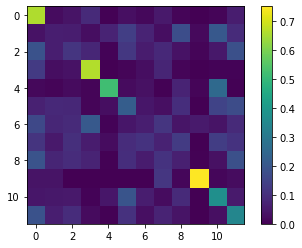

In [17]:
plt.imshow(model.transmat_)
plt.colorbar()

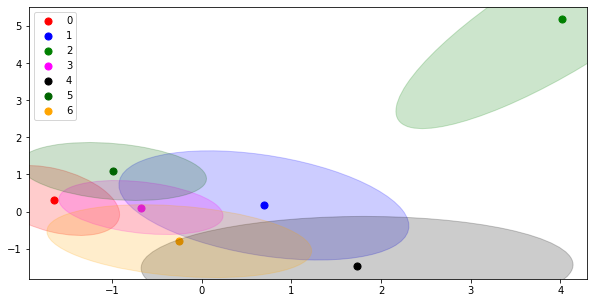

In [104]:
import matplotlib as mpl
fig1 = plt.figure(figsize=[10, 5])
ax1 = fig1.add_subplot(111)

colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey', 
          'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey',
         'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey',
         'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey']
for i, (m, c) in enumerate(zip(remodel.means_, remodel.covars_)):
    ax1.scatter(m[0], m[1], s=50, c=colors[i], label=str(i))
    utils.plot.plotEllipse(ax1, m, c, colors[i])
plt.legend()
plt.show()

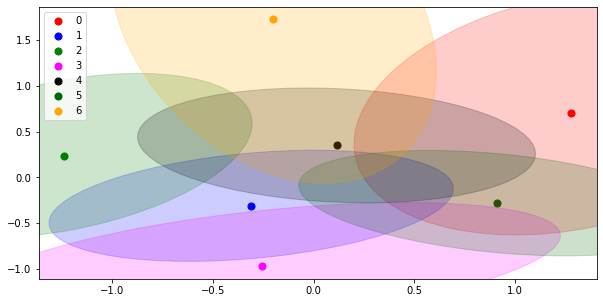

In [142]:
import matplotlib as mpl
fig1 = plt.figure(figsize=[10, 5])
ax1 = fig1.add_subplot(111)
colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey', ]
for i, (m, c) in enumerate(zip(remodel.means_, remodel.covars_)):
    ax1.scatter(m[0], m[1], s=50, c=colors[i], label=str(i))
    utils.plot.plotEllipse(ax1, m, c, colors[i])
plt.legend()
plt.show()

In [15]:
i=0
samples_list = []
states_list = []
while i < 10:
    samples, states = model.sample(7)
    samples_list.append(samples)
    states_list.append(states)
    i += 1
    print(i)
#remodel.sample(7)
#print(len(synthesized[0][1]))


1
2
3
4
5
6
7
8
9
10


In [16]:
len(samples_list[1][0]), len(states_list[1])

(418, 7)

In [5]:
# load mfcc/features databank according to num_length

PATH = '../../datasets/freesound.org/' #/wav/'
feat_database = utils.misc.loadFeatureDatabase(PATH + "features/")
feat_database.shape

  0%|          | 0/6327 [00:00<?, ?it/s]


NameError: name 'PATH' is not defined

In [52]:
from scipy import stats

# sample hmm and get mfcc
num_chunks = 20

overlap = 0.5
#alpha = 0.5
chunk_size = int(SR*.5)
overlap_size = int(np.round(overlap*chunk_size))
#out = np.zeros(int(chunk_size*(1+overlap*(num_chunks-1))))
out_size = int(chunk_size+(chunk_size-overlap_size)*(num_chunks-1))
out = np.zeros((num_chunks, out_size))
# inference
samples, states = model.sample(num_chunks)
print(out.shape)
overlap_it = 0

# Convert it to a NumPy array
a = np.array([np.array(x) for x in chunk_seq])
chunks = np.vstack(a)

out_wo = np.zeros(num_chunks*chunk_size)

#synthesize audio chunks and fuse
for i, sample in enumerate(samples):
    # compare closest mfcc and get audio chunk either pre computed or with sliding window
    #pear_coefs = np.asarray([stats.pearsonr(sample, mfcc_database[i][1:num_feats, :].flatten())[0] for i in range(len(mfcc_database))])
    pear_coefs = np.asarray([stats.pearsonr(sample[int(6*44):], mfcc_database[i, int(6*44):].flatten())[0] for i in range(len(mfcc_database))])
    pear_coefs[np.isnan(pear_coefs)] = 0
    
    chunk = chunks[np.argmax(np.abs(pear_coefs))]
    if i==0:
        out[i, :chunk_size] = chunk
        overlap_it = chunk_size-overlap_size
    else:
        out[i, overlap_it:overlap_it+chunk_size] = chunk
        overlap_it += (chunk_size-overlap_size)
    
    out_wo[i*chunk_size:i*chunk_size+chunk_size] = chunk

out = np.true_divide(out.sum(0),(out!=0).sum(0))
#out = np.asarray(out).flatten()

(20, 115772)


/opt/anaconda3/envs/aip37/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/envs/aip37/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


(115772,) (220500,)
[-0.00330353 -0.00245667 -0.00054169 ... -0.0009079  -0.00224304
 -0.00201416]
5512
-- 30


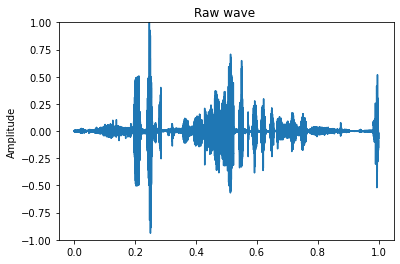

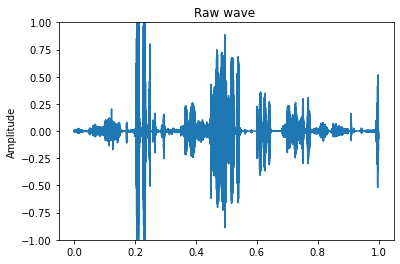

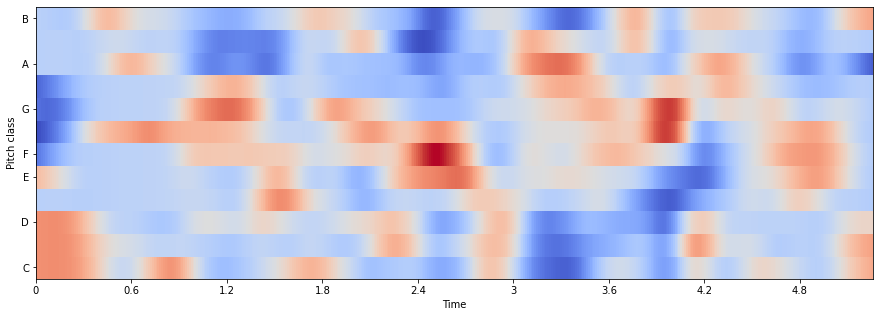

In [53]:
print(out.shape, out_wo.shape)
print((out_wo[int(.5*SR)-overlap_size:int(.5*SR)]-out[int(.5*SR)-overlap_size:int(.5*SR)]))
print(overlap_size)
print("--", np.sum(np.isnan(out)))
out[np.isnan(out)] = 0
display(ipd.Audio(out, rate=SR))
utils.plots.plotAudio(out)
utils.plots.plotAudio(out_wo)
display(ipd.Audio(out_wo, rate=SR))
# concatenate/play with/without alpha blending

chromagram = librosa.feature.chroma_cens(out, sr=SR, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
# add augmentation such as envelope, stereo etc in case of crowd laughter

In [335]:

overlap=0.25
chunk_size = 3
num_chunk = 3
temp = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
overlap_size = int(np.round(overlap*chunk_size))
out_size = int(chunk_size+(chunk_size-overlap_size)*(num_chunk-1))
print(out_size,overlap_size)
out = np.zeros((num_chunk, out_size))
overlap_it = 0
for i, c in enumerate(temp):
    if i==0:
        out[i, :chunk_size] = c
        print(out)
        overlap_it = chunk_size-overlap_size
    else:
        print("---")
        print( overlap_it, overlap_it+(chunk_size-overlap_size)+1)
        out[i, overlap_it:overlap_it+chunk_size] = c
        overlap_it += (chunk_size-overlap_size)

print(out)
print(np.true_divide(out.sum(0),(out!=0).sum(0)))

7 1
[[1. 2. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
---
2 5
---
4 7
[[1. 2. 3. 0. 0. 0. 0.]
 [0. 0. 4. 5. 6. 0. 0.]
 [0. 0. 0. 0. 7. 8. 9.]]
[1.  2.  3.5 5.  6.5 8.  9. ]


In [239]:
#display(pear_coefs)
print(samples.shape)
print(31*22)
# compare closest mfcc and get audio chunk either pre computed or with sliding window
# compare closest mfcc and get audio chunk either pre computed or with sliding window

pear_coefs = np.asarray([stats.pearsonr(samples[0], mfcc_database[i][1:num_feats, :].flatten())[0] for i in range(len(mfcc_database))])
pear_coefs[np.isnan(pear_coefs)] = 0
closest_elem = mfcc_database[np.argmax(np.abs(pear_coefs))][1:num_feats, :]
print(np.argmax(np.abs(pear_coefs)))
print( mfcc_database[np.argmax(np.abs(pear_coefs))][1:5, :])
chunks = []

# Convert it to a NumPy array
a = np.array([np.array(x) for x in chunk_seq])
chunks = np.vstack(a)
print(b.shape, len(mfcc_database))
len(chunks[np.argmax(np.abs(pear_coefs))])

(7, 682)
682
2325
[[  53.923798    44.703773    36.461704    40.04177     42.420967
    34.567265    33.28318     27.833885    15.560852    12.272169
     2.5229697   -1.7738235   -2.7417126   -7.352315   -12.10697
   -15.686716   -15.004792   -15.954638   -19.293129   -24.304577
   -19.006168    -0.5269009]
 [ -28.557587   -36.914024   -64.19968    -76.988434   -86.53612
   -92.74072    -96.70205    -97.31984    -97.11796    -92.201546
   -92.89122    -99.73746   -102.6479    -112.50388   -119.71454
  -125.64082   -125.491936  -129.82338   -132.77136   -132.34958
  -114.22674    -86.946625 ]
 [ -22.231773   -23.522915   -30.889679   -37.27694    -37.209667
   -44.121407   -45.457962   -40.039192   -45.270206   -52.59948
   -58.265285   -58.862465   -59.450157   -62.097076   -54.293198
   -53.32594    -55.018562   -58.435066   -60.208916   -59.72767
   -53.20172    -39.522003 ]
 [ -11.728152   -14.7392435  -29.248848   -36.071007   -40.12651
   -40.357765   -42.28378    -46.264587   -5

11025

In [12]:
from hmmlearn.hmm import GaussianHMM
if n_states is None:
    components = [5, 6, 8, 10, 12]
    hmms = [GaussianHMM(n_components=c) for c in components]
    map(lambda g: g.fit(per_data, per_lens), hmms)
    scores = map(lambda g: aic(g, per_data, per_lens), hmms)
    max_score, self.hmm = sorted(zip(scores, hmms))[0]
else:
    self.hmm = GaussianHMM(n_components=n_states)
    self.hmm.fit(per_data, per_lens)
ll = self.hmm.score(per_data, per_lens)
aic_ = aic(self.hmm, per_data, per_lens)
print "Goal HMM n_components", self.hmm.n_components, "Log likelihood", ll, "AIC", aic_

(3075,)

In [106]:
import pgv
G = pgv.AGraph(strict=False, directed=True, dpi=300)
T = remodel.hmm.transmat_
visited = []
start = None
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        t = round(T[i,j], 2)
        if t > 1e-10 and (i,j) not in visited:
            print(t*10)
            s = np.clip(7*t, 0, 1.5)
            G.add_edge(i, j, arrowsize=s)# label=t)
            visited.append((i,j))
    pi = round(goal_model.hmm.startprob_[i], 2)
    if pi == 1:
        start = i
for s in goal_model.final_states:
    n = G.get_node(s)
    n.attr['color'] = 'green'

ModuleNotFoundError: No module named 'pgv'

In [10]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=64, verbose=2).fit(pca_X)
labels = gmm.predict(pca_X)

Initialization 0
Initialization converged: True	 time lapse 506.00775s	 ll 18808.46868


(3075,)


(array([322., 270., 375., 319., 192., 193., 434., 458., 260., 252.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

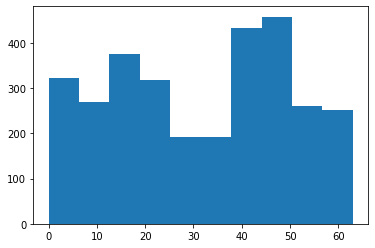

In [11]:
print(labels.shape)
plt.hist(labels)
#print(labels[1000:2000])

In [12]:
#%matplotlib inline
#pca_scaled_X = StandardScaler().fit_transform(pca_X)
pca_scaled_X = pca_X
plot_X = PCA(n_components=3).fit_transform(pca_scaled_X)

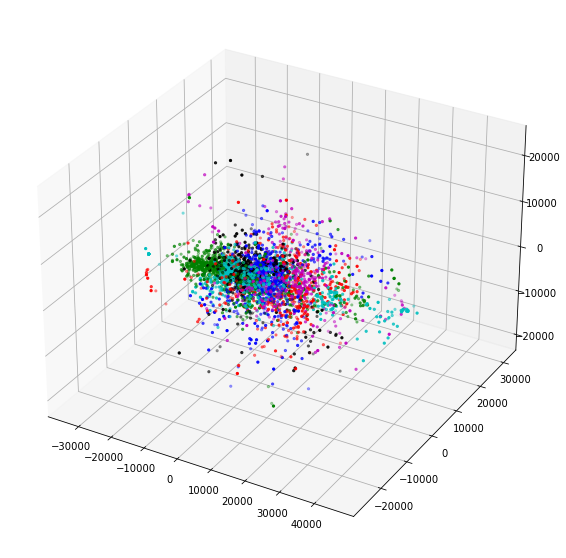

In [16]:
%matplotlib inline
colors = ['r', 'b', 'g', 'm', 'k', 'c']
fig1 = plt.figure(figsize=[20, 10])
ax1 = fig1.add_subplot(111, projection='3d')
for i in range(64):
    ax1.scatter(plot_X[labels==i, 0], plot_X[labels==i, 1], plot_X[labels==i, 2], c=colors[i%6], s=5.);
plt.show()

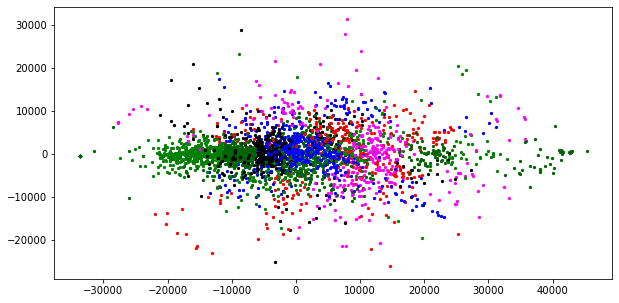

In [17]:
#%matplotlib inline
plot_X2 = PCA(n_components=2).fit_transform(pca_scaled_X)
colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey'] #'cyan',
fig2 = plt.figure(figsize=[10, 5])
ax2 = fig2.add_subplot(111)
for i in range(64):.-+
    ////////////////////////////////////////////////////////////////////
    ax2.scatter(plot_X2[labels==i, 0], plot_X2[labels==i, 1], c=colors[i%6], s=5);
plt.show()
#plt.savefig('mfcc_spectral_features.png')

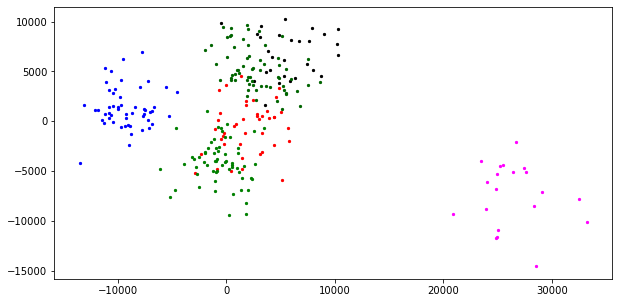

In [15]:
#%matplotlib inline
plot_X2 = PCA(n_components=2).fit_transform(pca_X)
colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey'] #'cyan',
fig2 = plt.figure(figsize=[10, 5])
ax2 = fig2.add_subplot(111)
for i in range(6):
    ax2.scatter(plot_X2[labels==i, 0], plot_X2[labels==i, 1], c=colors[i], s=5);
plt.show()

In [155]:
target = 0
idx = np.where(labels==target)[0][0]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][5]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][10]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][15]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][20]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][30]
display(ipd.Audio(chunks[idx, :], rate=SR))


0


In [149]:
idx = np.where(labels==target)[0][10]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1


In [150]:
idx = np.where(labels==target)[0][20]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1


In [151]:
idx = np.where(labels==target)[0][30]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1
